# Sentimental Analysis On Amazon’s Alexa Reviews Using Machine Learning And Deep Learning Approaches

## Dataset
- Rating：評價，1~5顆星。
- Date：日期。
- Variation：產品型號。
- Verified_Reviews：顧客評論，以文字形式呈現。
- Feedback：回饋，1為正面回饋；0為負面回饋

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

## 讀取資料

In [ ]:
df = pd.read_csv('amazon_alexa.tsv',sep = '\t',quoting =3) # quoting = 3 會完全輸出""
df.head(5)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


5 個欄位 
- rating: 該等級的評價
- date: 日期
- variation: 產品型號
- verified_reviews: 評論的全文
- feedback: 1 -> 正面 0 -> 負面

# EDA

In [ ]:
df.info() # 沒有缺失值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
rating              3150 non-null int64
date                3150 non-null object
variation           3150 non-null object
verified_reviews    3150 non-null object
feedback            3150 non-null int64
dtypes: int64(2), object(3)
memory usage: 123.1+ KB


In [ ]:
df.describe() 
# p(Y=1) ~ 91.8% 

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


## Feedback

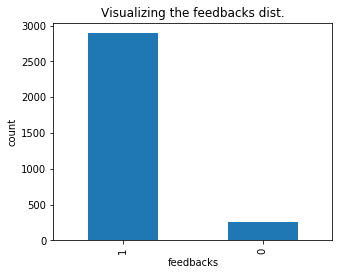

rating                                             
           count      mean       std  min  25%  50%  75%  max
feedback                                                     
0          257.0  1.373541  0.484688  1.0  1.0  1.0  2.0  2.0
1         2893.0  4.737643  0.546544  3.0  5.0  5.0  5.0  5.0

In [ ]:
# feedback
df['feedback'].value_counts().plot.bar(figsize = (5, 4))
plt.title('Visualizing the feedbacks dist.')
plt.xlabel('feedbacks')
plt.ylabel('count')
plt.show()

df.groupby('feedback').describe()
# 偏向不平衡資料,主要分數看AUC

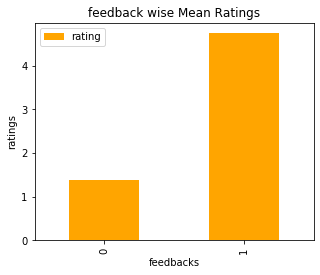

In [ ]:
# feedback ＆ ratings
df.groupby('feedback').mean()[['rating']].plot.bar(color = 'orange', figsize=(5, 4))
plt.title("feedback wise Mean Ratings")
plt.xlabel('feedbacks')
plt.ylabel('ratings')
plt.show()

大多評論都是正面的,是一個不平衡資料集,因此待會評估方法以ROC曲線下面積AUC為主

## Rating

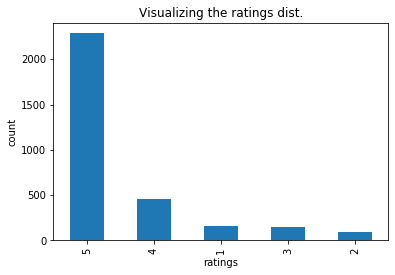

feedback                                   
          count mean  std  min  25%  50%  75%  max
rating                                            
1         161.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2          96.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3         152.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
4         455.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
5        2286.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0

In [ ]:
# rating
df['rating'].value_counts().plot.bar()
plt.title('Visualizing the ratings dist.')
plt.xlabel('ratings')
plt.ylabel('count')
plt.show()

df.groupby('rating').describe()

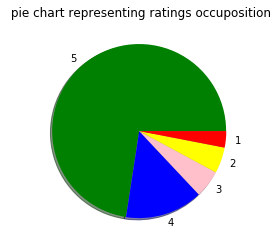

In [ ]:
labels = '5', '4', '3', '2', '1'
sizes = [2286, 455, 161, 152, 96]
colors = ['green', 'blue', 'pink', 'yellow', 'red']
explode = [0.001, 0.001, 0.001, 0.001, 0.001]

plt.pie(sizes, labels = labels, colors = colors, explode = explode, shadow = True)
plt.title(' pie chart representing ratings occuposition')
plt.show()

- 從 3 到 5 的評分被歸類為正面評論，從 1 到 2 的評分被歸類為負面評論
- 總體而言，亞馬遜 Alexa 的評論非常好，被歸類為正面 91.8%（2893 條評論）。
- 評論中普遍存在等於 5 的評分。

## date

In [ ]:
df.date.describe()

count          3150
unique           77
top       30-Jul-18
freq           1603
Name: date, dtype: object

In [ ]:
df['date'].value_counts().head()

30-Jul-18    1603
29-Jul-18     482
28-Jul-18     250
26-Jul-18      85
31-Jul-18      81
Name: date, dtype: int64

## variation

In [ ]:
df.groupby('variation').mean()[['rating']]
Data = {'Variation': ['Black Dot','Charcoal Fabric','Configuration: Fire TV Stick','Black Plus','Black  Show','Black',
            'Black  Spot','White  Dot','Heather Gray Fabric','White  Spot','White','Sandstone Fabric','White  Show',
             'White  Plus','Oak Finish','Walnut Finish'],
        'rating_mean': [4.453488,4.730233,4.591429,4.370370,4.490566,4.233716,4.311203,4.423913,4.694268,4.311927,4.142857,
              4.355556,4.282353,4.358974,4.857143,4.888889]
       }   
data = pd.DataFrame(Data,columns=['Variation','rating_mean'])
data  

,Variation,rating_mean
0,Black Dot,4.453488
1,Charcoal Fabric,4.730233
2,Configuration: Fire TV Stick,4.591429
3,Black Plus,4.370370
4,Black Show,4.490566
5,Black,4.233716
6,Black Spot,4.311203
7,White Dot,4.423913
8,Heather Gray Fabric,4.694268
9,White Spot,4.311927


Text(0.5, 1.0, 'Visualizing the variations dist.')

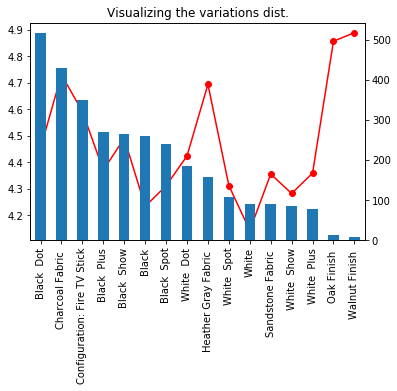

In [ ]:
# variation
ax = plt.plot(data['Variation'], data['rating_mean'],color='red', marker='o')
# ax = data.groupby('Variation').mean()[['rating_mean']].plot(secondary_y=True,linestyle='-',marker='o')
df['variation'].value_counts().plot(kind = 'bar',secondary_y=True)
plt.title('Visualizing the variations dist.')
# ax.set_xticklabels((''))

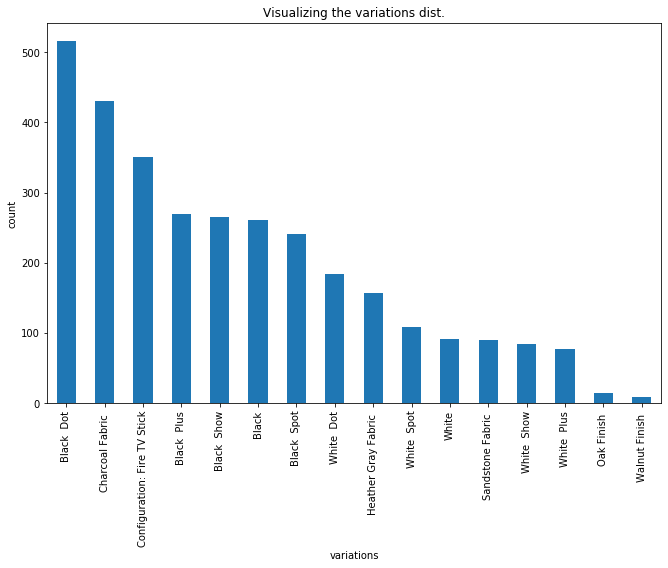

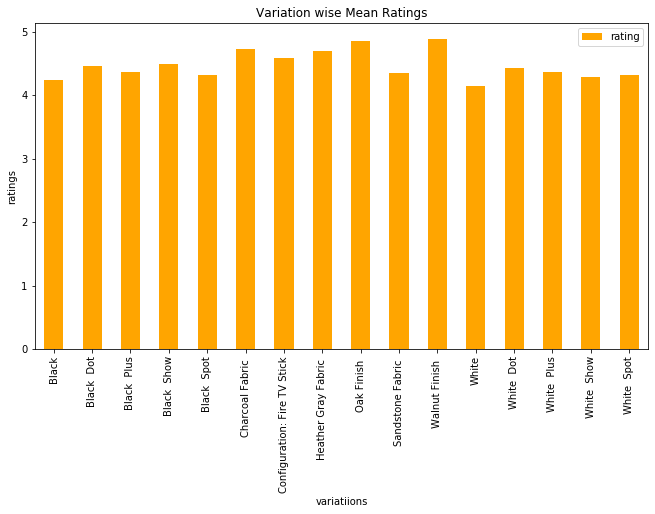

In [ ]:
# variation
df['variation'].value_counts().plot.bar( figsize = (11, 7))
plt.title('Visualizing the variations dist.')
plt.xlabel('variations')
plt.ylabel('count')
plt.show()


#variation & rating
df.groupby('variation').mean()[['rating']].plot.bar(color = 'orange', figsize=(11, 6))
plt.title("Variation wise Mean Ratings")
plt.xlabel('variatiions')
plt.ylabel('ratings')
plt.show()


- 所有變體的平均評分均高於 4，因此我們可以得出結論，variation不會影響客戶對產品的滿意度。


## Length

一般來說，較長的評論更準確，因為客戶會詳細解釋他給出的評級。因此，檢查評論在我們的數據集中的長度很重要，增加length欄位

In [ ]:
df['length'] = df['verified_reviews'].apply(len)
df.shape 

(3150, 6)

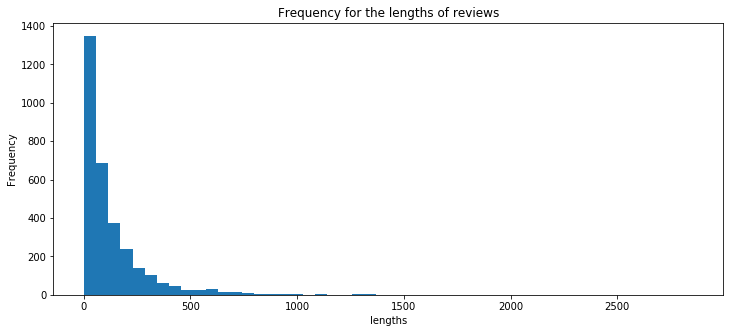

count    3150.000000
mean      132.673651
std       182.526953
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

In [ ]:
df['length'].plot.hist(figsize = (12, 5),bins=50)
plt.title("Frequency for the lengths of reviews")
plt.xlabel('lengths')
plt.ylabel('Frequency')
plt.show()

df.length.describe()

- 最短的評論有 1 個字符，最長的評論有 2851 個字符。
- 平均而言，評論的長度為 132 個字符。

In [ ]:
## 正面評論＆length
df[df["feedback"]==1].describe()

,rating,feedback,length
count,2893.000000,2893.0,2893.000000
mean,4.737643,1.0,125.274456
std,0.546544,0.0,175.036515
min,3.000000,1.0,1.000000
25%,5.000000,1.0,29.000000
50%,5.000000,1.0,70.000000
75%,5.000000,1.0,155.000000
max,5.000000,1.0,2853.000000


In [ ]:
## 負面評論＆length
df[df["feedback"]==0].describe()

,rating,feedback,length
count,257.000000,257.0,257.000000
mean,1.373541,0.0,215.964981
std,0.484688,0.0,236.895519
min,1.000000,0.0,1.000000
25%,1.000000,0.0,53.000000
50%,1.000000,0.0,137.000000
75%,2.000000,0.0,291.000000
max,2.000000,0.0,1688.000000



- 平均而言，如果評論是正面的或負面的，評論的長度會有所不同。正面評論的平均長度為 124 個字符，負面評論的平均長度為 215 個字符。
- 我們可以得出結論，平均而言，對產品不滿意的人傾向於寫更長的評論。<br>
正面評價更容易撰寫，因為您只能說“這是一款很棒的產品”並給予很高的評價。在撰寫負面評論時，該人可能想解釋他或她對產品不滿意的原因，這需要更長的文字。

In [ ]:
df[df['length'] == 1]['verified_reviews'].iloc[0]

'😍'

In [ ]:
print(df[df['length'] == 20]['verified_reviews'].iloc[0])
df[df['length'] == 20]['verified_reviews'].iloc[1]

"Love, Love, Love!!"


'Sad joke. Worthless.'

In [ ]:
df[df['length'] == 2853]['verified_reviews'].iloc[0]

'"Incredible piece of technology.I have this right center of my living room on an island kitchen counter. The mic and speaker goes in every direction and the quality of the sound is quite good. I connected the Echo via Bluetooth to my Sony soundbar on my TV but find the Echo placement and 360 sound more appealing. It\'s no audiophile equipment but there is good range and decent bass. The sound is more than adequate for any indoor entertaining and loud enough to bother neighbors in my building. The knob on the top works great for adjusting volume. This is my first Echo device and I would imagine having to press volume buttons (on the Echo 2) a large inconvenience and not as precise. For that alone I would recommend this over the regular Echo (2nd generation).The piece looks quality and is quite sturdy with some weight on it. The rubber material on the bottom has a good grip on the granite counter-- my cat can even rub her scent on it without tipping it over.This order came with a free P

## verified_reviews

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 20')

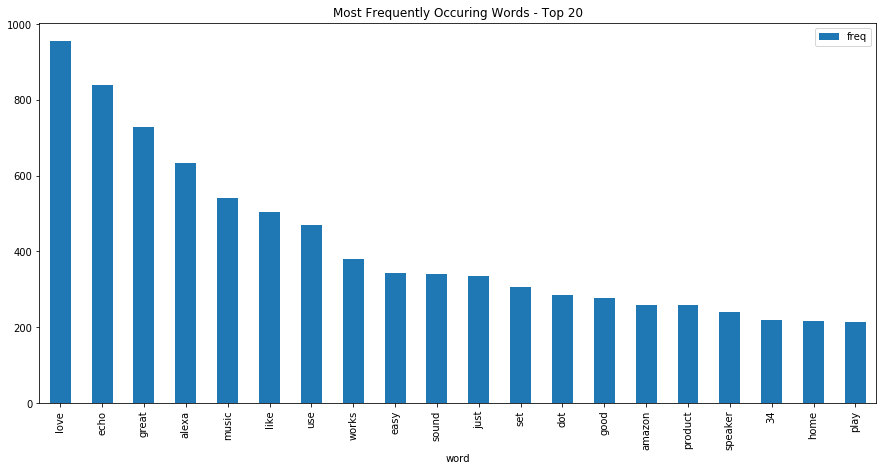

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(stop_words = 'english') # 停頓詞
words = cv.fit_transform(df.verified_reviews)
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
# print(cv.vocabulary_.items())
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 7))
plt.title("Most Frequently Occuring Words - Top 20")

Text(0.5, 1.0, 'WordCloud - Vocabulary from Reviews')

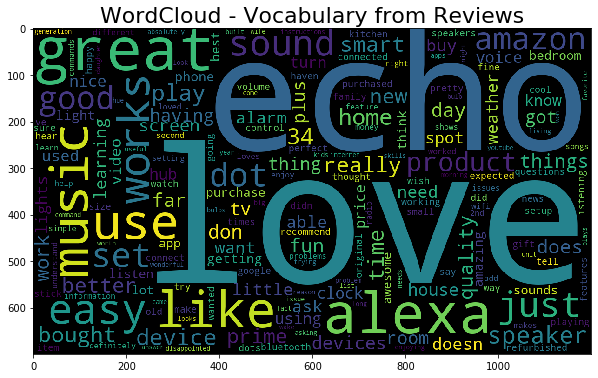

In [ ]:
# 文字雲
from wordcloud import WordCloud

wordcloud = WordCloud(width = 1200, height = 700).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from Reviews", fontsize = 22)

通過快速瀏覽 wordcloud，我們可以看到來自正面評價的詞更為普遍。<br>
為了可視化每種評論的最常用詞，讓我們將 wordcloud 中的正面評論和負面評論分開。

In [ ]:



positive = df[df['feedback'] == 1]
p = len(positive)
negative = df[df['feedback'] == 0]
n = len(negative)

Text(0.5, 1.0, 'WordCloud - Vocabulary from Reviews')

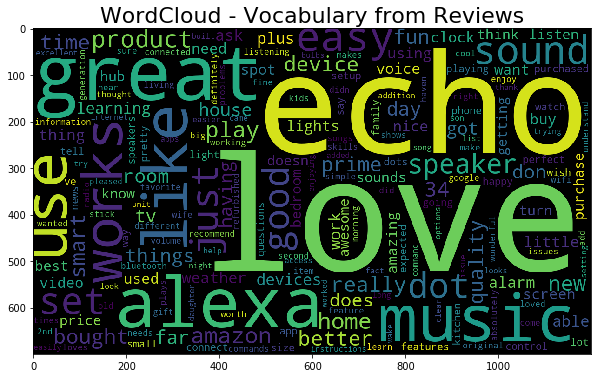

In [ ]:
# Wordcloud for the positive reviews
pos_words = cv.fit_transform(positive.verified_reviews)
sum_words = pos_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
# print(cv.vocabulary_.items())
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
wordcloud = WordCloud(width = 1200, height = 700).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from Reviews", fontsize = 22)

Text(0.5, 1.0, 'WordCloud - Vocabulary from Reviews')

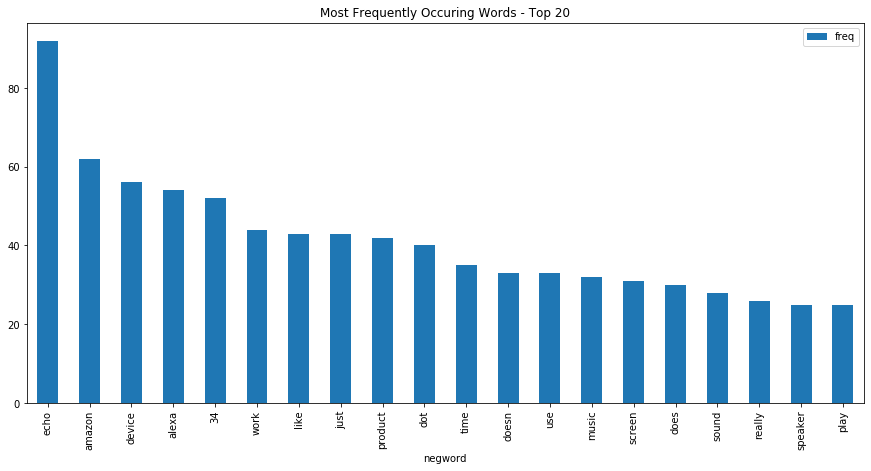

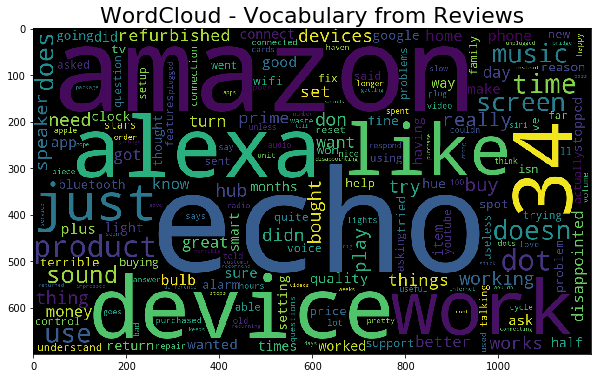

In [ ]:

# Wordcloud for the negative reviews:
neg_words = cv.fit_transform(negative.verified_reviews)
sum_words = neg_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
# print(cv.vocabulary_.items())
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['negword', 'freq'])
frequency.head(20).plot(x='negword', y='freq', kind='bar', figsize=(15, 7))
plt.title("Most Frequently Occuring Words - Top 20")
wordcloud = WordCloud(width = 1200, height = 700).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from Reviews", fontsize = 22)

# 資料前處理

The analysis will focus on the content of the reviews, so, from now on some information are not necessary: length, date and rating.

In [ ]:
reviews_df = df.drop(['date', 'rating'], axis = 1)
reviews_df.head()

,variation,verified_reviews,feedback,length
0,Charcoal Fabric,Love my Echo!,1,13
1,Charcoal Fabric,Loved it!,1,9
2,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,Charcoal Fabric,Music,1,5


Transforming categorical values into numerical.
許多機器學習算法不能直接處理分類數據，因此將分類數據轉換為數值以準備模型進行訓練是一種常見的做法。
one hot encoding 是一種創建類別的方法， 0 表示negative和 1 表示positive.

In [ ]:
variation_dummies = pd.get_dummies(reviews_df['variation'], drop_first = True)
# Avoid Dummy Variable trap which occurs when one variable can be predicted from the other.

In [ ]:
variation_dummies.head()

,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,Walnut Finish,White,White Dot,White Plus,White Show,White Spot
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
# 現在我們將變異數據從分類數據轉換為數值數據，可以從原始數據框中刪除該列：
reviews_df.drop(['variation'], axis = 1,inplace=True) # inplace = True不創建新的目標，直接對原始對象進行修改
reviews_df.head()

,verified_reviews,feedback,length
0,Love my Echo!,1,13
1,Loved it!,1,9
2,"""Sometimes while playing a game, you can answe...",1,197
3,"""I have had a lot of fun with this thing. My 4...",1,174
4,Music,1,5


In [ ]:
# Joining the original dataframe with the transformed data:
reviews_df = pd.concat([reviews_df, variation_dummies], axis = 1)
reviews_df.head()

,verified_reviews,feedback,length,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,Walnut Finish,White,White Dot,White Plus,White Show,White Spot
0,Love my Echo!,1,13,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Loved it!,1,9,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,"""Sometimes while playing a game, you can answe...",1,197,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,"""I have had a lot of fun with this thing. My 4...",1,174,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Music,1,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


## 文字前處理


In [ ]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords
import string
from nltk.stem.porter import *

In [ ]:
# Let's define a pipeline to clean up all the messages 
# The pipeline performs the following: (1) remove punctuation, (2) remove stopwords, (3) remove short words (2 characters and less)
# (4) perform stemming
def message_cleaning(message):
    stemmer = PorterStemmer()
    Test_punc_removed = [char for char in message if char not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)
    Test_punc_removed_join_clean = [stemmer.stem(word) for word in Test_punc_removed_join.split() if word.lower() not in stopwords.words('english') and len(word)>2]
    return Test_punc_removed_join_clean

In [ ]:
#test the function
verified_reviews_clean=reviews_df['verified_reviews'].apply(message_cleaning)
verified_reviews_clean.head(5)

0                                         [love, echo]
1                                               [love]
2    [sometim, play, game, answer, question, correc...
3    [lot, fun, thing, old, learn, dinosaur, contro...
4                                              [music]
Name: verified_reviews, dtype: object

In [ ]:
## countvectorizer
#perform Count Vectorization
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = CountVectorizer(analyzer=message_cleaning)
reviews_countvectorizer = vectorizer.fit_transform(reviews_df['verified_reviews'])

In [ ]:
print(vectorizer.get_feature_names())

['072318', '100', '1000', '100x', '1010', '1030pm', '1100sf', '1220', '129', '12am', '150', '1964', '1990', '1990’', '1gb', '1rst', '1st', '200', '2000', '2017', '2030', '229', '2448', '247', '24ghz', '299', '2999', '2nd', '2or', '2origin', '2packag', '300', '30so', '334', '342nd', '3434', '34a34', '34alexa', '34alexa34', '34card34', '34certifi', '34computer34', '34cycl', '34cycle34', '34dot34', '34drop', '34first', '34fixes34', '34fun34', '34group34', '34hear34', '34hmm', '34hmmm', '34hub', '34i', '34im', '34it34', '34late', '34learn', '34light34', '34lights34', '34listen34', '34minor', '34never', '34outlet34', '34personal34', '34philip', '34play', '34second', '34she34', '34show', '34skills34', '34smart', '34smart34', '34sorri', '34spying34', '34tell', '34the', '34thi', '34thick34', '34thing', '34thong', '34tri', '34troubl', '34turn', '34visual34', '34wake34m', '34warehouse34', '34what', '360', '399', '3999', '3dot', '3rd', '3x', '40000', '4am', '4th', '5am”', '5ghz', '5th', '600', '6

In [ ]:
reviews_countvectorizer.shape

(3150, 3297)

In [ ]:
# first let's drop the column and create the vectorized array version to dataframe
reviews_df.drop(['verified_reviews'], axis=1, inplace=True)
reviews = pd.DataFrame(reviews_countvectorizer.toarray())
reviews.head()

,0,1,2,3,4,5,6,7,8,9,...,3287,3288,3289,3290,3291,3292,3293,3294,3295,3296
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Now let's concatenate them together
reviews_df = pd.concat([reviews_df, reviews], axis=1)

In [ ]:
reviews_df.head()

,feedback,length,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,...,3287,3288,3289,3290,3291,3292,3293,3294,3295,3296
0,1,13,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,9,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,197,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,174,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,5,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Let's drop the target column
X = reviews_df.drop(['feedback','length'],axis=1)
y = reviews_df['feedback']
print(X.shape)
print(y.shape)

(3150, 3312)
(3150,)


In [ ]:
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2520, 3312)
(2520,)
(630, 3312)
(630,)


# 建立模型 (sklearn)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve,auc

## Naive-Bayes

condusion matrix:
 [[ 22  27]
 [ 13 568]]
Area under test roc : 0.7133021883452176
Testing Accuracy : 0.9365079365079365
Testing Precision : 0.9546218487394958
Testing Recall : 0.9776247848537005
Testing f1-score : 0.9659863945578232


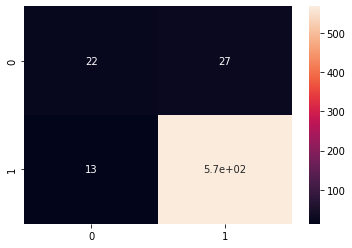

In [ ]:
#train a Naive-Bayes Classifier
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train, y_train)

#predict and evaluate
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print('condusion matrix:\n',cm)
sns.heatmap(cm, annot = True)
# Accuracy,Precision,Recall,F1-score
print('Area under test roc :',roc_auc_score(y_test,y_pred))
print("Testing Accuracy :", accuracy_score(y_test, y_pred))
print("Testing Precision :", precision_score(y_test, y_pred))
print("Testing Recall :", recall_score(y_test, y_pred))
print("Testing f1-score :", f1_score(y_test, y_pred))

In [ ]:
# Feature engineering -> handling unbalanced dataset
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
smote=SMOTE()
X_sm,y_sm=smote.fit_sample(X_train,y_train)  ### Oversampling the training dataset.

condusion matrix:
 [[ 34  15]
 [ 53 528]]
Area under test roc : 0.8013277600196704
Testing Accuracy : 0.8920634920634921
Testing Precision : 0.9723756906077348
Testing Recall : 0.9087779690189329
Testing f1-score : 0.9395017793594306


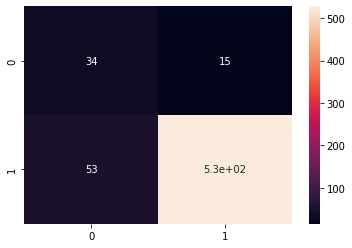

In [ ]:
# SMOTE oversampling
model =MultinomialNB()
model.fit(X_sm,y_sm)
y_pred = model.predict(X_test)


cm = confusion_matrix(y_test, y_pred)
print('condusion matrix:\n',cm)
sns.heatmap(cm, annot = True)
# Accuracy,Precision,Recall,F1-score
print('Area under test roc :',roc_auc_score(y_test,y_pred))
print("Testing Accuracy :", accuracy_score(y_test, y_pred))
print("Testing Precision :", precision_score(y_test, y_pred))
print("Testing Recall :", recall_score(y_test, y_pred))
print("Testing f1-score :", f1_score(y_test, y_pred))

## Logistic Regression

condusion matrix:
 [[ 21  23]
 [  5 581]]
Area under test roc : 0.7343701520322681
Testing Accuracy : 0.9555555555555556
Testing Precision : 0.9619205298013245
Testing Recall : 0.9914675767918089
Testing f1-score : 0.9764705882352941


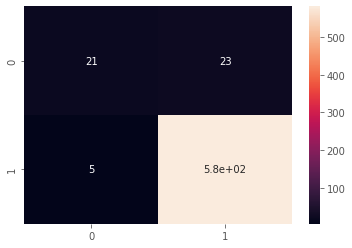

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print('condusion matrix:\n',cm)
sns.heatmap(cm, annot = True)
# Accuracy,Precision,Recall,F1-score
print('Area under test roc :',roc_auc_score(y_test,y_pred))
print("Testing Accuracy :", accuracy_score(y_test, y_pred))
print("Testing Precision :", precision_score(y_test, y_pred))
print("Testing Recall :", recall_score(y_test, y_pred))
print("Testing f1-score :", f1_score(y_test, y_pred))

condusion matrix:
 [[ 34  10]
 [ 34 552]]
Area under test roc : 0.8573533974557865
Testing Accuracy : 0.9301587301587302
Testing Precision : 0.9822064056939501
Testing Recall : 0.9419795221843004
Testing f1-score : 0.9616724738675958


/home/iebi/anaconda3/envs/iebi-gpu/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


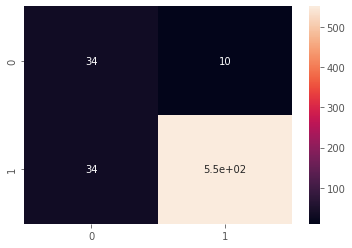

In [ ]:
# SMOTE oversampling
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty = 'none',solver='lbfgs')
model.fit(X_sm, y_sm)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print('condusion matrix:\n',cm)
sns.heatmap(cm, annot = True)
# Accuracy,Precision,Recall,F1-score
print('Area under test roc :',roc_auc_score(y_test,y_pred))
print("Testing Accuracy :", accuracy_score(y_test, y_pred))
print("Testing Precision :", precision_score(y_test, y_pred))
print("Testing Recall :", recall_score(y_test, y_pred))
print("Testing f1-score :", f1_score(y_test, y_pred))

## Decsion Tree

condusion matrix:
 [[ 31  18]
 [ 32 549]]
Area under test roc : 0.7887878042783378
Testing Accuracy : 0.9206349206349206
Testing Precision : 0.9682539682539683
Testing Recall : 0.9449225473321858
Testing f1-score : 0.9564459930313588


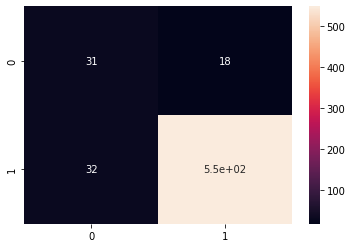

In [ ]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print('condusion matrix:\n',cm)
sns.heatmap(cm, annot = True)
# Accuracy,Precision,Recall,F1-score
print('Area under test roc :',roc_auc_score(y_test,y_pred))
print("Testing Accuracy :", accuracy_score(y_test, y_pred))
print("Testing Precision :", precision_score(y_test, y_pred))
print("Testing Recall :", recall_score(y_test, y_pred))
print("Testing f1-score :", f1_score(y_test, y_pred))


condusion matrix:
 [[ 30  14]
 [ 58 528]]
Area under test roc : 0.7914210363015824
Testing Accuracy : 0.8857142857142857
Testing Precision : 0.974169741697417
Testing Recall : 0.9010238907849829
Testing f1-score : 0.9361702127659575


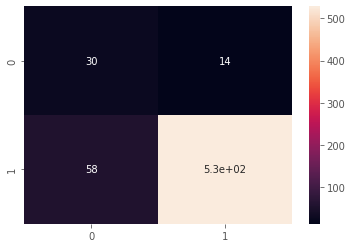

In [ ]:
# SMOTE oversampling
model = DecisionTreeClassifier(criterion='entropy',splitter='random')
model.fit(X_sm, y_sm)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print('condusion matrix:\n',cm)
sns.heatmap(cm, annot = True)
# Accuracy,Precision,Recall,F1-score
print('Area under test roc :',roc_auc_score(y_test,y_pred))
print("Testing Accuracy :", accuracy_score(y_test, y_pred))
print("Testing Precision :", precision_score(y_test, y_pred))
print("Testing Recall :", recall_score(y_test, y_pred))
print("Testing f1-score :", f1_score(y_test, y_pred))


## Random Forest

condusion matrix:
 [[ 21  25]
 [  2 582]]
Area under test roc : 0.7265485407980942
Testing Accuracy : 0.9571428571428572
Testing Precision : 0.9588138385502472
Testing Recall : 0.9965753424657534
Testing f1-score : 0.9773299748110831


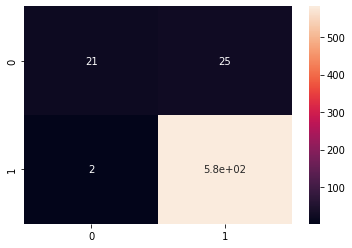

In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print('condusion matrix:\n',cm)
sns.heatmap(cm, annot = True)
# Accuracy,Precision,Recall,F1-score
print('Area under test roc :',roc_auc_score(y_test,y_pred))
print("Testing Accuracy :", accuracy_score(y_test, y_pred))
print("Testing Precision :", precision_score(y_test, y_pred))
print("Testing Recall :", recall_score(y_test, y_pred))
print("Testing f1-score :", f1_score(y_test, y_pred))

condusion matrix:
 [[ 31  15]
 [ 40 544]]
Area under test roc : 0.8027099463966647
Testing Accuracy : 0.9126984126984127
Testing Precision : 0.9731663685152058
Testing Recall : 0.9315068493150684
Testing f1-score : 0.9518810148731409


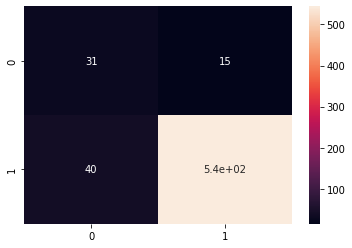

In [ ]:
# SMOTE oversampling
model = RandomForestClassifier(criterion='entropy',n_estimators=200,max_depth=50)
model.fit(X_sm, y_sm)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print('condusion matrix:\n',cm)
sns.heatmap(cm, annot = True)
# Accuracy,Precision,Recall,F1-score
print('Area under test roc :',roc_auc_score(y_test,y_pred))
print("Testing Accuracy :", accuracy_score(y_test, y_pred))
print("Testing Precision :", precision_score(y_test, y_pred))
print("Testing Recall :", recall_score(y_test, y_pred))
print("Testing f1-score :", f1_score(y_test, y_pred))

## XGBoost

condusion matrix:
 [[  6  40]
 [  4 580]]
Area under test roc : 0.5617927337701012
Testing Accuracy : 0.9301587301587302
Testing Precision : 0.9354838709677419
Testing Recall : 0.9931506849315068
Testing f1-score : 0.9634551495016611


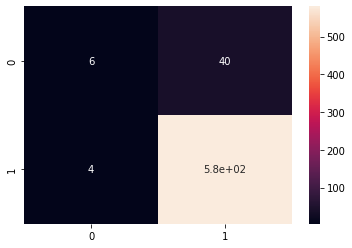

In [ ]:
model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print('condusion matrix:\n',cm)
sns.heatmap(cm, annot = True)
# Accuracy,Precision,Recall,F1-score
print('Area under test roc :',roc_auc_score(y_test,y_pred))
print("Testing Accuracy :", accuracy_score(y_test, y_pred))
print("Testing Precision :", precision_score(y_test, y_pred))
print("Testing Recall :", recall_score(y_test, y_pred))
print("Testing f1-score :", f1_score(y_test, y_pred))

condusion matrix:
 [[ 37   9]
 [103 481]]
Area under test roc : 0.813988981536629
Testing Accuracy : 0.8222222222222222
Testing Precision : 0.9816326530612245
Testing Recall : 0.8236301369863014
Testing f1-score : 0.8957169459962756


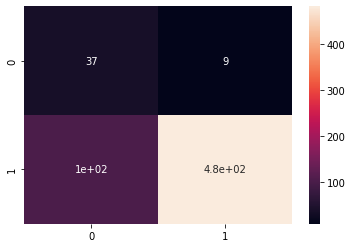

In [ ]:
# SMOTE oversampling
model = XGBClassifier(booster='dart')
model.fit(X_sm, y_sm)

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print('condusion matrix:\n',cm)
sns.heatmap(cm, annot = True)
# Accuracy,Precision,Recall,F1-score
print('Area under test roc :',roc_auc_score(y_test,y_pred))
print("Testing Accuracy :", accuracy_score(y_test, y_pred))
print("Testing Precision :", precision_score(y_test, y_pred))
print("Testing Recall :", recall_score(y_test, y_pred))
print("Testing f1-score :", f1_score(y_test, y_pred))

# NLP with Neural Nets

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [ ]:
#get again the vanilla dataset
reviews_df_nn=pd.read_csv('amazon_alexa.tsv',sep='\t')

In [ ]:
#apply cleaning function and store it in dataframe
reviews_only=pd.DataFrame(reviews_df_nn['verified_reviews'].apply(message_cleaning))

In [ ]:
reviews_only['verified_reviews_joined']=reviews_only['verified_reviews'].apply(lambda x: " ".join(x))

In [ ]:
reviews_only

,verified_reviews,verified_reviews_joined
0,"[love, echo]",love echo
1,[love],love
2,"[sometim, play, game, answer, question, correc...",sometim play game answer question correctli al...
3,"[lot, fun, thing, old, learn, dinosaur, contro...",lot fun thing old learn dinosaur control light...
4,[music],music
5,"[receiv, echo, gift, need, anoth, bluetooth, s...",receiv echo gift need anoth bluetooth someth p...
6,"[without, cellphon, cannot, use, mani, featur,...",without cellphon cannot use mani featur ipad s...
7,"[think, 5th, one, ive, purchas, work, get, one...",think 5th one ive purchas work get one everi r...
8,"[look, great]",look great
9,"[love, i’v, listen, song, haven’t, heard, sinc...",love i’v listen song haven’t heard sinc childh...


In [ ]:
# the total words present in the dataset
list_of_words = []
for i in reviews_only['verified_reviews']:
    for j in i:
        list_of_words.append(j)

In [ ]:
# the total number of unique words
total_words=len(list(set(list_of_words)))
total_words

3297

In [ ]:
maxlen = -1
for doc in reviews_only['verified_reviews_joined']:
    tokens = nltk.word_tokenize(doc)
    if(maxlen < len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is:", maxlen)

The maximum number of words in any document is: 262


In [ ]:
# split the data into test and train  
X = reviews_only['verified_reviews']
y = reviews_df_nn['feedback']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2520,)
(2520,)
(630,)
(630,)


In [ ]:
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(X_train)

# Training data
X_train = tokenizer.texts_to_sequences(X_train)
# Testing data
X_test = tokenizer.texts_to_sequences(X_test)
# Add padding to training and testing to make all vectors the same size
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [ ]:
# from keras.layers.core import Dense,Dropout,Activation,Flatten
# create the model
embedding_vector_length = 64
model = Sequential()
model.add(Embedding(total_words, embedding_vector_length, input_length=maxlen))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
# Bi-Directional RNN and LSTM9
model.add(LSTM(256,return_sequences=True))
model.add(LSTM(256,return_sequences=True))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
history=model.fit(X_train, y_train, batch_size = 64, validation_split = 0.2, epochs = 10)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 262, 64)           211008    
_________________________________________________________________
conv1d (Conv1D)              (None, 262, 32)           6176      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 131, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 131, 256)          295936    
_________________________________________________________________
lstm_1 (LSTM)                (None, 131, 256)          525312    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 1)                 1

/home/iebi/anaconda3/envs/iebi-gpu/lib/python3.7/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


condusion matrix:
 [[ 21  31]
 [ 16 562]]
Area under test roc : 0.6880822464732499
Testing Accuracy : 0.9253968253968254
Testing Precision : 0.9477234401349073
Testing Recall : 0.972318339100346
Testing f1-score : 0.9598633646456021


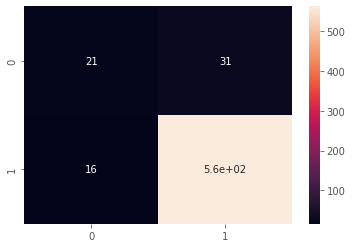

In [ ]:
# make prediction
y_pred = model.predict_classes(X_test)
cm = confusion_matrix(y_test, y_pred)
print('condusion matrix:\n',cm)
sns.heatmap(cm, annot = True)
# Accuracy,Precision,Recall,F1-score
print('Area under test roc :',roc_auc_score(y_test,y_pred))
print("Testing Accuracy :", accuracy_score(y_test, y_pred))
print("Testing Precision :", precision_score(y_test, y_pred))
print("Testing Recall :", recall_score(y_test, y_pred))
print("Testing f1-score :", f1_score(y_test, y_pred))

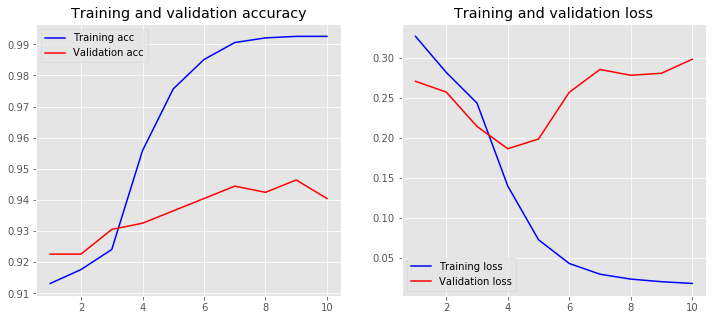

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)

In [ ]:
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
smote=SMOTE()
X_sm,y_sm=smote.fit_sample(X_train,y_train)  ### Oversampling the training dataset.

In [ ]:
# SMOTE oversampling
# from keras.layers.core import Dense,Dropout,Activation,Flatten
# create the model
embedding_vector_length = 64
model = Sequential()
model.add(Embedding(total_words, embedding_vector_length, input_length=maxlen))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
# Bi-Directional RNN and LSTM9
model.add(LSTM(256,return_sequences=True))
model.add(LSTM(256,return_sequences=True))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
history=model.fit(X_sm, y_sm, batch_size = 64, validation_split = 0.2, epochs = 5)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 262, 64)           211008    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 262, 32)           6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 131, 32)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 131, 256)          295936    
_________________________________________________________________
lstm_4 (LSTM)                (None, 131, 256)          525312    
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

/home/iebi/anaconda3/envs/iebi-gpu/lib/python3.7/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


condusion matrix:
 [[ 40  12]
 [ 93 485]]
Area under test roc : 0.8041655576257651
Testing Accuracy : 0.8333333333333334
Testing Precision : 0.9758551307847082
Testing Recall : 0.8391003460207612
Testing f1-score : 0.9023255813953489


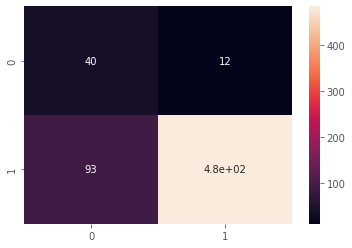

In [ ]:
# SMOTE oversampling
# make prediction
y_pred = model.predict_classes(X_test)
cm = confusion_matrix(y_test, y_pred)
print('condusion matrix:\n',cm)
sns.heatmap(cm, annot = True)
# Accuracy,Precision,Recall,F1-score
print('Area under test roc :',roc_auc_score(y_test,y_pred))
print("Testing Accuracy :", accuracy_score(y_test, y_pred))
print("Testing Precision :", precision_score(y_test, y_pred))
print("Testing Recall :", recall_score(y_test, y_pred))
print("Testing f1-score :", f1_score(y_test, y_pred))

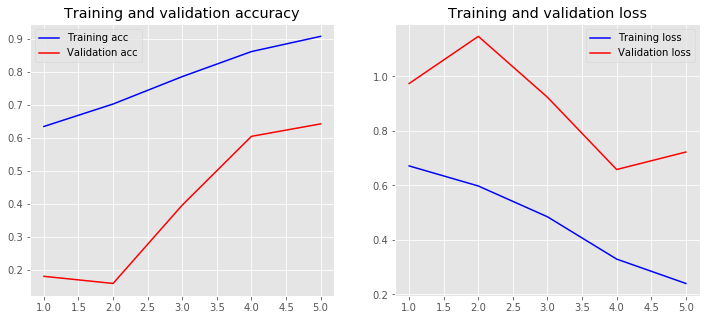

In [ ]:
# SMOTE oversampling
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)

# Reference
- [Practical ML Part 2: NLP on Amazon Alexa Reviews](https://medium.com/analytics-vidhya/practical-ml-part-2-nlp-on-amazon-alexa-reviews-4b0b3a15f4bf)
- [Sentiment-Analysis-on-Product-Reviews](https://github.com/Darzan21/Sentiment-Analysis-on-Product-Reviews/blob/main/Product%20Review%20NLP%20(NaiveBayes%2C%20LSTM).ipynb)
- [Topic Modeling and Sentiment Analysis on Amazon Alexa Reviews — Part II](https://towardsdatascience.com/topic-modeling-and-sentiment-analysis-on-amazon-alexa-reviews-part-ii-47ff96541d19)
- [淺談機器學習的效能衡量指標 (2) -- ROC/AUC 曲線](https://ithelp.ithome.com.tw/articles/10229049)
- [在 Python 中繪製 ROC 曲線](https://www.delftstack.com/zh-tw/howto/python/plot-roc-curve-python/)
- [Alexa ,Whats your review ?](https://www.kaggle.com/gsdeepakkumar/alexa-whats-your-review)
- Monika Kanojiya and Deepti Deepak Nikumbh,"Sentimental Analysis on Amazon’s Alexa Reviews using ML and DL approach: A Comparative study",International Journal of Future Generation Communication and Networking,Vol. 13, No. 4, (2020), pp. 3177–3186.
